In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image

import flickr_api
from flickr_api import Photo
from sklearn.cluster import DBSCAN

import torch

from dataset.load import LoadDataset
from dataset.utils import load_credentials
from utils.vis import make_tensor, visualize_grid

api_key, api_secret = load_credentials()
flickr_api.set_keys(api_key=api_key, api_secret=api_secret)

In [3]:
# Load dataset and count number of photos
path = "data/paris_1000_test.h5"
dataset = LoadDataset(path)
print(dataset.size(), "photos")

999 photos


# Baseline: clustering using only location (lat/lon)

In [4]:
# Get features from dataset
it = dataset.get()
X = []
for i, row in enumerate(it):
    metadata, _, embedding = row

    # Location
    lat = float(metadata["location"]["latitude"])
    lon = float(metadata["location"]["longitude"])
    
    # Tags    
    tags = " ".join([tag["text"] for tag in metadata["tags"]])

    # Embedding
    emb = embedding.tolist()

    id = int(metadata["id"])
    X.append([id, lat, lon])

X = np.asarray(X)
X.shape

(999, 3)

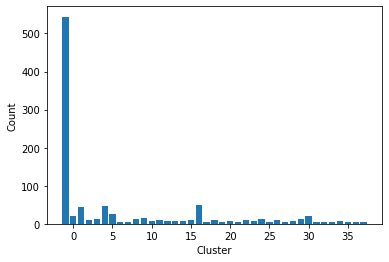

In [5]:
# Sampling on a smaller subset
X_train = X[:, 1:]

# Train clustering using DBSCAN
kms_per_radian = 6371.0088
meters = 30
epsilon = (meters * 0.001) / kms_per_radian
db = DBSCAN(eps=epsilon, algorithm='ball_tree', metric='haversine')
db.fit(np.radians(X_train))
y_train = db.labels_

# Plot
fig, ax = plt.subplots()
ax.bar(*np.unique(y_train, return_counts=True))
ax.set_xlabel("Cluster")
ax.set_ylabel("Count")
plt.show()

In [6]:
# Get images in clusters
cluster_imgs = {}
for label in set(y_train):
    if label == -1: continue
    photos_id = X[y_train == label, 0]
    cluster_imgs[label] = []
    subset = np.random.choice(photos_id.shape[0], size=min(photos_id.shape[0], 6), replace=False)
    for photo_id in photos_id[subset]:
        _, img, _ = dataset.get_id(int(photo_id))
        cluster_imgs[label].append(img)

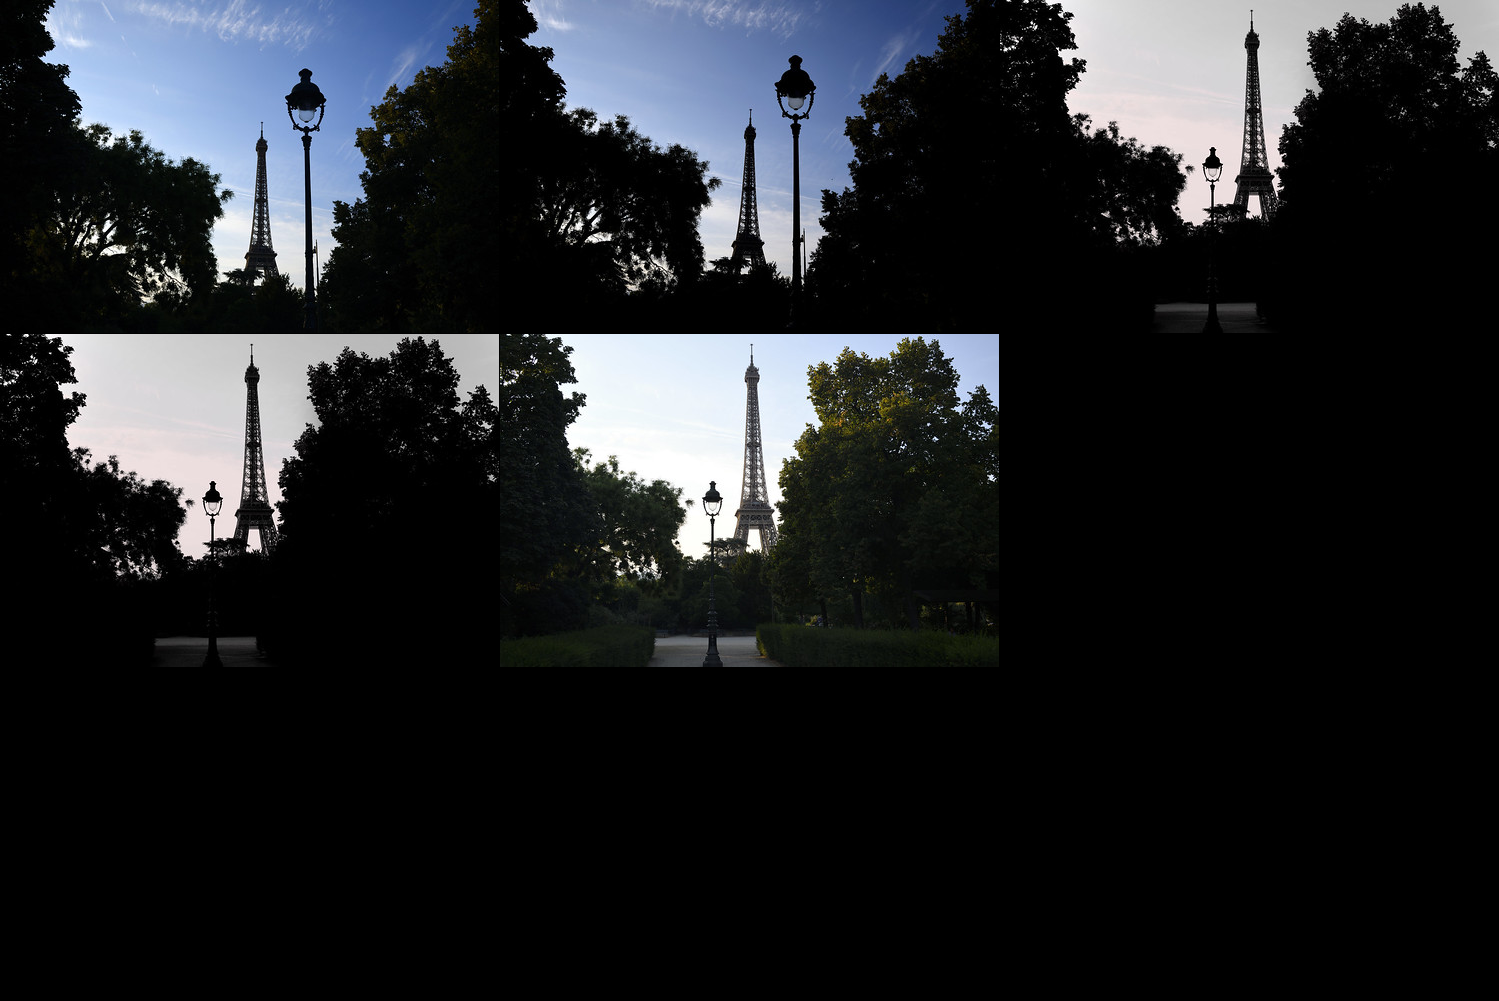

In [7]:
# Visualize photos from the same cluster
cluster_label = 33
grid = visualize_grid(make_tensor(cluster_imgs[cluster_label]))
Image.fromarray(grid.astype("uint8"))

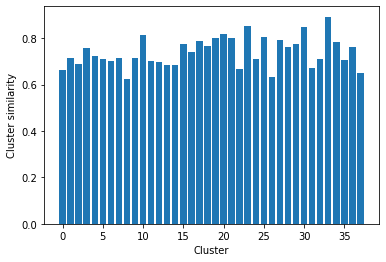

In [8]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_cluster_sim(X):
    embedding_X = [dataset.get_id(int(photo_id))[2] for photo_id in X[:, 0]]
    embedding_X = np.stack(embedding_X, axis=0)
    return cosine_similarity(embedding_X).mean()

# Quantitative measure of the clusters
cluster_similarities = {}
for label in set(y_train):
    if label == -1: continue
    cluster_X = X[y_train == label]
    cluster_sim = compute_cluster_sim(cluster_X)
    cluster_similarities[label] = cluster_sim

# Plot
fig, ax = plt.subplots()
ax.bar(cluster_similarities.keys(), [cluster_similarities[k] for k in cluster_similarities.keys()])
ax.set_xlabel("Cluster")
ax.set_ylabel("Cluster similarity")
plt.show()

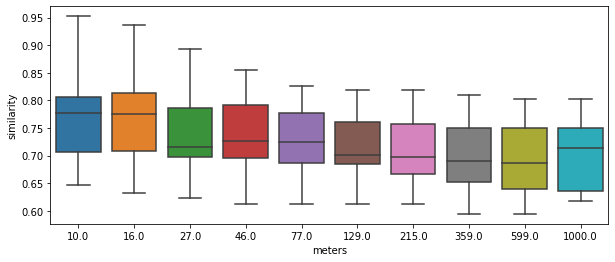

In [9]:
def plot_distance_vs_sim(X):
    df = pd.DataFrame()
    for meters in np.logspace(1, 3, num=10):
        X_train = X[:, 1:]

        # Train clustering using DBSCAN
        kms_per_radian = 6371.0088
        epsilon = (int(meters) * 0.001) / kms_per_radian
        db = DBSCAN(eps=epsilon, algorithm='ball_tree', metric='haversine')
        db.fit(np.radians(X_train))
        y_train = db.labels_

        # Similarities
        for label in set(y_train):
            if label == -1: continue
            cluster_X = X[y_train == label]
            cluster_sim = compute_cluster_sim(cluster_X)
            df = df.append({
                "meters": int(meters),
                "similarity": cluster_sim
            }, ignore_index=True)
        
    return df

exp_meters = plot_distance_vs_sim(X)
fig, ax = plt.subplots(figsize=(10,4))
sns.boxplot(x="meters", y="similarity", data=exp_meters, ax=ax)
plt.show()

In [10]:
df = pd.DataFrame()
for label in set(y_train):
    if label == -1: continue
    photos_id = X[y_train == label, 0]
    for photo_id in photos_id:
        metadata, _, _ = dataset.get_id(int(photo_id))
        df = df.append({
            "lat": float(metadata["location"]["latitude"]),
            "lon": float(metadata["location"]["longitude"]),
            "id": metadata["id"],
            "title": str(metadata["title"]) if "title" in metadata.keys() else "(No title)",
            "cluster": int(label)
        }, ignore_index=True)
df.head()

,cluster,id,lat,lon,title
0,0.0,28434540197,48.873501,2.294833,Ball and Chain
1,0.0,30592530328,48.873466,2.295311,Le triomphe de 1810 by Jean-Pierre Cortrot (Ar...
2,0.0,31458424207,48.873588,2.295058,Eiffel tower from the roof of Arc de Triomphe ...
3,0.0,31463760127,48.874072,2.294861,Arc de Triomphe - La Paix de 1815 by Antoine É...
4,0.0,32500117358,48.873501,2.294833,Quiet Morning


In [11]:
from geojsonio import embed
from utils.geojson import GeoJson

geojson_data = GeoJson().to_geojson(df,
    'cluster', # column for grouping to the same pin color
    'lat', # latitude column name
    'lon', # longitude column name
    [c for c in df.columns] # metadata to add in the geojson
)
geojson_data.save_to("geojson-viewer/data.geojson")

# Image feature representation

In [22]:
# Get features from dataset
it = dataset.get()
idx = []
images = []
for i, row in enumerate(it):
    metadata, img, embedding = row
    # ID
    idx.append(metadata["id"])
    # Embedding
    images.append(img)

len(images)

999

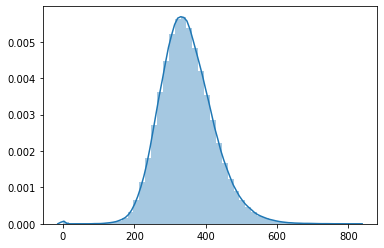

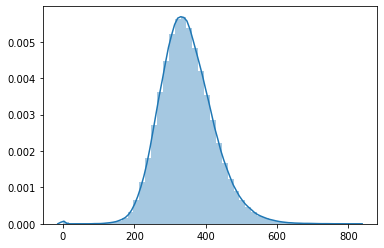

KeyboardInterrupt: 

In [23]:
from clustering.embedding import WSL, VGG16

for model in [VGG16(-10), VGG16(-5), VGG16()]:
    model.eval()
    with torch.no_grad():
        embeddings = forward(model, images)
    fig, ax = plt.subplots()
    sns.distplot(dist_img(embeddings).reshape(-1), ax=ax)
    plt.show()

# Entire pipeline

In [13]:
from sklearn.preprocessing import MinMaxScaler
from clustering.distances import dist_geo, dist_img, dist_tag
from clustering.embedding import WSL, VGG16, forward
from clustering.tags import vectorizer
from geojsonio import embed
from utils.geojson import GeoJson

In [14]:
# Get features from dataset
it = dataset.get()
idx = []
location = []
tags = []
embeddings = []
for i, row in enumerate(it):
    metadata, img, embedding = row
    # ID
    idx.append(metadata["id"])
    # Location
    lat = float(metadata["location"]["latitude"])
    lon = float(metadata["location"]["longitude"])
    location.append([lat, lon])
    # Tags
    t = " ".join([tag["text"] for tag in metadata["tags"]])
    tags.append(t)
    # Embedding
    embeddings.append(img)

# Batch forward for embedding
model = VGG16(-15)
model.eval()
with torch.no_grad():
    embeddings = forward(model, embeddings)
_, dim_embeddings = embeddings.shape

# Batch TF-IDF for tags
tags = vectorizer(tags)
_, dim_tags = tags.shape

# Stack altogether features
X = np.hstack([np.asarray(location), embeddings, tags.todense()])
X.shape

(999, 51785)

In [15]:
# Build each distance matrix
scaler = MinMaxScaler()
dist_matrix_geo = scaler.fit_transform(dist_geo(X[:, :2]))
dist_matrix_img = scaler.fit_transform(dist_img(X[:, 2:2+dim_embeddings]))
dist_matrix_tag = scaler.fit_transform(dist_img(X[:, 2+dim_embeddings:]))

# Weighted combination
alpha, beta, gamma = 0.0, 1.0, 0.0
assert alpha + beta + gamma == 1
dist_matrix = alpha*dist_matrix_geo + beta*dist_matrix_img + gamma*dist_matrix_tag

# Statistics
print(dist_matrix.min(), dist_matrix.mean(), dist_matrix.max())
dist_matrix.shape

0.0 0.5703974014755292 1.0


(999, 999)

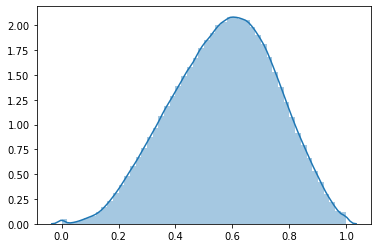

In [16]:
sns.distplot(dist_matrix_img.reshape(-1))

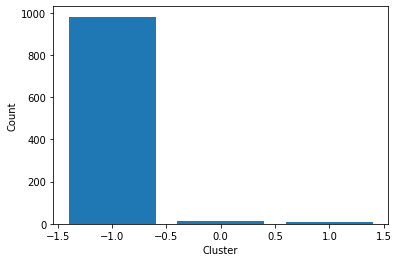

Min/Max 7 11
Mean 9.0
Std 2.0


In [9]:
# Play with eps and min_samples
db = DBSCAN(eps=0.1, min_samples=5, metric="precomputed")
db.fit_predict(dist_matrix)
y_pred = db.labels_

# Visualization of cluster sizes
fig, ax = plt.subplots()
ax.bar(*np.unique(y_pred, return_counts=True))
ax.set_xlabel("Cluster")
ax.set_ylabel("Count")
plt.show()
_, counts = np.unique(y_pred, return_counts=True)
print("Min/Max", np.min(counts[1:]), np.max(counts[1:]))
print("Mean", np.mean(counts[1:]))
print("Std", np.std(counts[1:]))

In [190]:
# Get images in clusters
cluster_imgs = {}
for label in set(y_train):
    if label == -1: continue
    photos_id = [idx[i] for i in range(y_pred.shape[0]) if y_pred[i] == label]
    cluster_imgs[label] = []
    subset = np.random.choice(len(photos_id), size=min(len(photos_id), 6), replace=False)
    for photo_id in [photos_id[i] for i in subset]:
        _, img, _ = dataset.get_id(int(photo_id))
        cluster_imgs[label].append(img)

# Visualize photos from the same cluster
cluster_label = 11
grid = visualize_grid(make_tensor(cluster_imgs[cluster_label]))
Image.fromarray(grid.astype("uint8"))

ValueError: max() arg is an empty sequence

In [191]:
# Build GeoJSON
df = pd.DataFrame()
for label in set(y_pred):
    if label == -1: continue
    photos_id = [idx[i] for i in range(y_pred.shape[0]) if y_pred[i] == label]
    for photo_id in photos_id:
        metadata, _, _ = dataset.get_id(int(photo_id))
        df = df.append({
            "lat": float(metadata["location"]["latitude"]),
            "lon": float(metadata["location"]["longitude"]),
            "id": metadata["id"],
            "title": str(metadata["title"]) if ("title" in metadata.keys() and metadata["title"] != "") else "(No title)",
            "url": metadata["photo_file_urls"]["Small"],
            "cluster": int(label)
        }, ignore_index=True)

# Export GeoJSON
geojson_data = GeoJson().to_geojson(df, 
    'cluster', # column for grouping to the same pin color
    'lat', # latitude column name
    'lon', # longitude column name
    [c for c in df.columns] # metadata to add in the geojson
)
geojson_data.save_to("geojson-viewer/data.geojson")
df.head()

,cluster,id,lat,lon,title,url
0,0.0,28575632897,48.842094,2.322094,Paris At Sunset,https://live.staticflickr.com/1763/28575632897...
1,0.0,28587621467,48.827567,2.348327,Paris street art,https://live.staticflickr.com/1806/28587621467...
2,0.0,28982790947,48.842364,2.321634,Eiffel Tower lit up,https://live.staticflickr.com/940/28982790947_...
3,0.0,29635959058,48.846537,2.365370,Let's Dock and Roll,https://live.staticflickr.com/1808/29635959058...
4,0.0,29837005057,48.858249,2.294425,Tour eiffel,https://live.staticflickr.com/1891/29837005057...
